In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Define file paths and audience labels
file_info = {
    "layperson": "/content/drive/My Drive/Colab Notebooks/layperson_stories_final.xlsx",
    "credit_officer": "/content/drive/My Drive/Colab Notebooks/credit_officer_stories_final.xlsx",
    "general": "/content/drive/My Drive/Colab Notebooks/general_stories_final.xlsx"
}

# Read each file and assign the audience label
dfs = []
for audience, path in file_info.items():
    df = pd.read_excel(path)
    df = df.rename(columns={df.columns[0]: "narrative"})  # Ensure column is named "narrative"
    df["audience"] = audience
    dfs.append(df)

# Concatenate into a single DataFrame
df_narratives = pd.concat(dfs, ignore_index=True)


In [3]:
df_narratives

,narrative,audience
0,The AI model has predicted that the loan appli...,layperson
1,The AI model reviewed your loan application an...,layperson
2,The AI model has predicted that the loan appli...,layperson
3,The AI model predicted that the loan applicati...,layperson
4,The AI model predicted that the loan applicati...,layperson
...,...,...
85,The AI model predicted that the applicant's lo...,general
86,The AI model predicted that the applicant's lo...,general
87,The AI model predicted that the applicant's lo...,general
88,The AI model predicted that the applicant's lo...,general


In [4]:
!pip install -q umap-learn sentence-transformers matplotlib scikit-learn pandas


In [5]:
from sentence_transformers import SentenceTransformer

# Use a model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings
embeddings = model.encode(df_narratives["narrative"].tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
import umap
import numpy as np

# Reduce to 2D for plotting
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


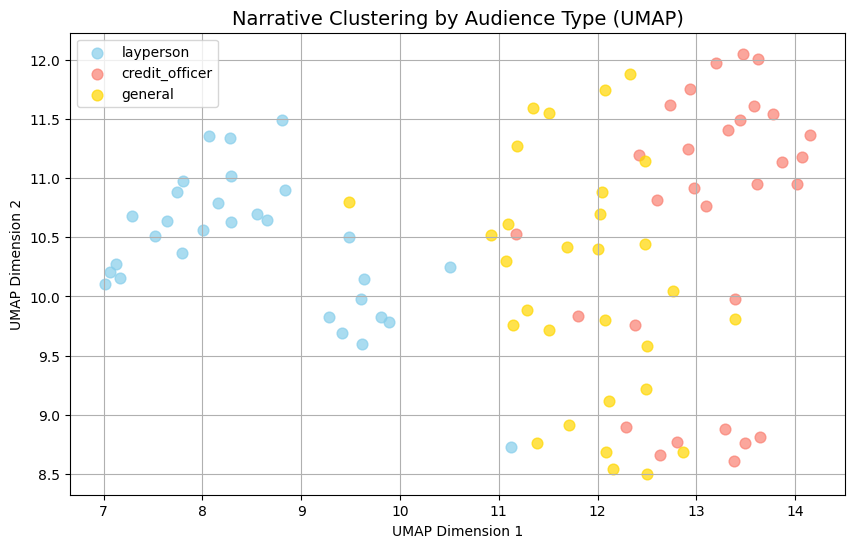

In [7]:
import matplotlib.pyplot as plt

audience_labels = df_narratives["audience"].values
colors = {"layperson": "skyblue", "credit_officer": "salmon", "general": "gold"}

plt.figure(figsize=(10, 6))
for audience in colors:
    ix = audience_labels == audience
    plt.scatter(embeddings_2d[ix, 0], embeddings_2d[ix, 1],
                label=audience, alpha=0.7, s=60, c=colors[audience])

plt.title("Narrative Clustering by Audience Type (UMAP)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Number of instances per audience
n_instances = len(df_narratives) // df_narratives["audience"].nunique()

# Create instance IDs that repeat for each audience group
df_narratives["instance_id"] = list(range(n_instances)) * df_narratives["audience"].nunique()

# Check
print(df_narratives.head(10))


                                           narrative   audience  instance_id
0  The AI model has predicted that the loan appli...  layperson            0
1  The AI model reviewed your loan application an...  layperson            1
2  The AI model has predicted that the loan appli...  layperson            2
3  The AI model predicted that the loan applicati...  layperson            3
4  The AI model predicted that the loan applicati...  layperson            4
5  The AI model predicted that the loan applicati...  layperson            5
6  The AI model predicted that the loan applicati...  layperson            6
7  The AI model has predicted that the loan appli...  layperson            7
8  The AI model predicted that the loan applicati...  layperson            8
9  The AI model predicted that the loan applicati...  layperson            9


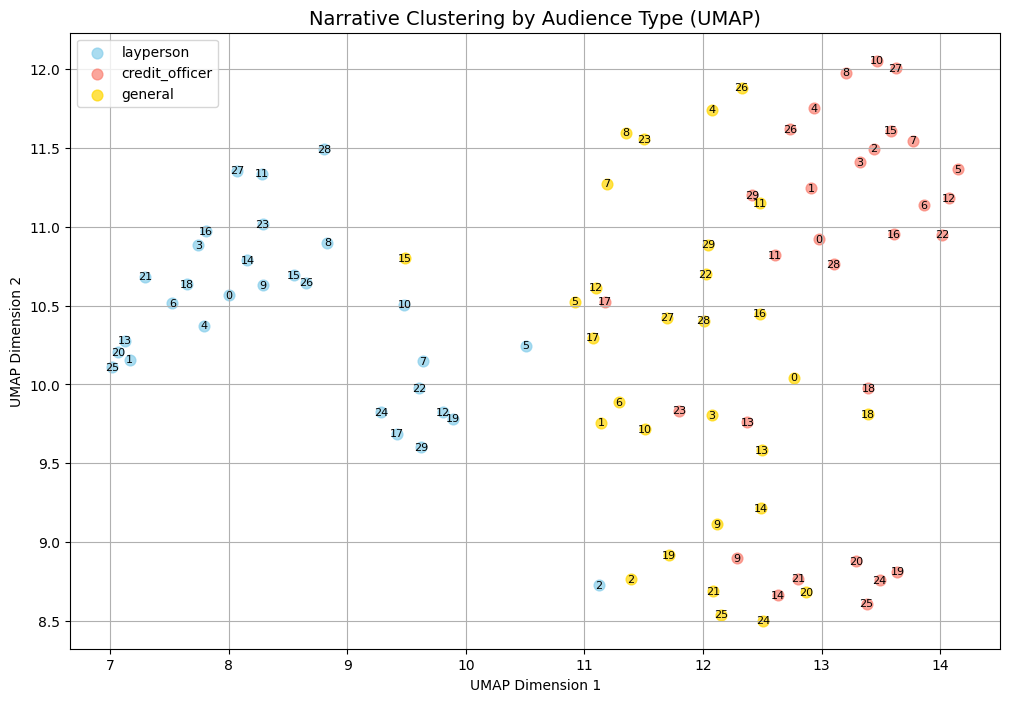

In [9]:
import matplotlib.pyplot as plt

# Number of instances per audience
n_instances = len(df_narratives) // df_narratives["audience"].nunique()

# Create instance IDs (0 to n_instances-1) repeated for each audience
df_narratives["instance_id"] = list(range(n_instances)) * df_narratives["audience"].nunique()

# Color mapping
colors = {"layperson": "skyblue", "credit_officer": "salmon", "general": "gold"}
audience_labels = df_narratives["audience"].values

plt.figure(figsize=(12, 8))

# Plot each audience type separately
for audience in colors:
    ix = audience_labels == audience
    plt.scatter(embeddings_2d[ix, 0], embeddings_2d[ix, 1],
                label=audience, alpha=0.7, s=60, c=colors[audience])

# Add instance_id labels on top of the dots
for i, txt in enumerate(df_narratives["instance_id"]):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(txt),
             fontsize=8, ha='center', va='center')

plt.title("Narrative Clustering by Audience Type (UMAP)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


Evaluate clustering

In [10]:
from sklearn.metrics import silhouette_score

# Convert labels to numeric
label_map = {"layperson": 0, "credit_officer": 1, "general": 2}
numeric_labels = [label_map[a] for a in audience_labels]

score = silhouette_score(embeddings, numeric_labels, metric="cosine")
print(f"Silhouette Score (cosine distance): {score:.3f}")

'''
Interpretation:

    Score ~ 1: tight, well-separated clusters

    Score ~ 0: overlapping

    Score < 0: incorrect clustering
'''

Silhouette Score (cosine distance): 0.145


'\nInterpretation:\n\n    Score ~ 1: tight, well-separated clusters\n\n    Score ~ 0: overlapping\n\n    Score < 0: incorrect clustering\n'

In [11]:
df_embeddings = pd.DataFrame(embeddings)
df_embeddings["audience"] = audience_labels
df_embeddings.to_csv("narrative_embeddings.csv", index=False)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


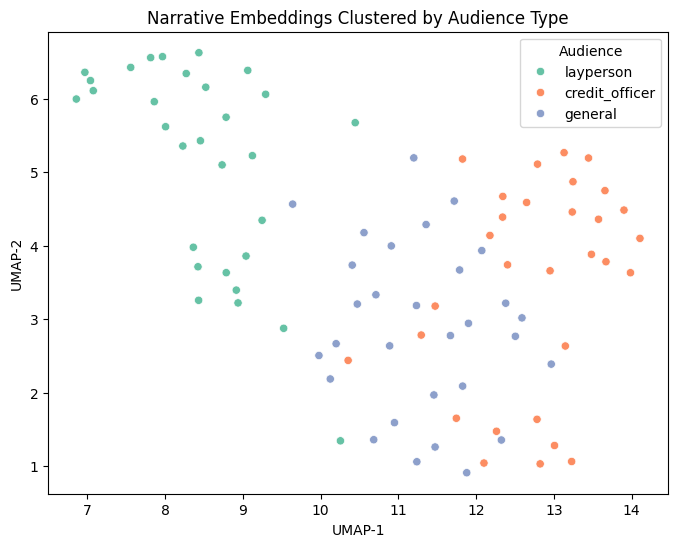


Classification Accuracy: 0.9259259259259259

Classification Report:
                 precision    recall  f1-score   support

credit_officer       0.82      1.00      0.90         9
       general       1.00      0.78      0.88         9
     layperson       1.00      1.00      1.00         9

      accuracy                           0.93        27
     macro avg       0.94      0.93      0.92        27
  weighted avg       0.94      0.93      0.93        27


Confusion Matrix:
 [[9 0 0]
 [2 7 0]
 [0 0 9]]


In [12]:
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#1. Embed narratives

model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(df_narratives["narrative"].tolist(), show_progress_bar=True)
#2. UMAP projection for visualization

reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

df_narratives["x"] = embedding_2d[:, 0]
df_narratives["y"] = embedding_2d[:, 1]
#3. Plot clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_narratives, x="x", y="y", hue="audience", palette="Set2")
plt.title("Narrative Embeddings Clustered by Audience Type")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Audience")
plt.show()
#4. Classify audience type based on embedding

X_train, X_test, y_train, y_test = train_test_split(
embeddings,
df_narratives["audience"],
test_size=0.3,
stratify=df_narratives["audience"],
random_state=42
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#5. Results

print("\nClassification Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))